# PhaseRetrieval <a class="anchor" id="phaseretrieval"></a>

Author: Dr. Pavel Kliuiev

PhaseRetrieval is a Python-based framework for solution of the phase problem widely encountered in optics. The framework incorporates the full workflow for phase retrieval: image pre-processing, reconstruction of images by phase retrieval algorithms and post-processing of reconstructed images (such as image registration).

<img src="framework_scheme.png" alt="Drawing" style="width: 600px;"/>


The phase retrieval problem is a mathematical problem of recovering an unknown object distribution (an unknown function) from the known modulus of its Fourier transform. Phase retrieval algorithms ([Gerchberg-Saxton-1972](#Gechrberg-Saxton-1972)) make use of available information (such as real- or complex-valuedness of the object or its low-resolution optical image). The problem is widely encountered in imaging and signal processing and its applications range from adaptive optics for large space telescopes and 3D microscopic imaging of cells to imaging through turbulent atmosphere and visualisation of the valence orbitals of organic molecules. 

## Table of Contents:

 > Section [Image processing for phase retrieval](#image-processing-for-phase-retrieval) lists typical steps needed for processing of raw images prior to the application of phase retrieval algorithms.

> Section [Phase retrieval](#phase-retrieval) provides a detailed description of the steps for the recovery of the object distributions either when only Fourier modulus is available or in case of availability of both the Fourier- and the object-domain data.

> Section "Image registration" lists algorithms for alignment of the phase or/and amplitude images reconstructed with phase retrieval algorithms.


* 00\. [PhaseRetrieval](#phaseretrieval)
    * 00.1\. [Source code](#source-code)
    * 00.3\. [Requirements](#requirements)
    * 00.4\. [License](#license)
* 1\. [Image processing for phase retrieval](#image-processing-for-phase-retrieval)
    * 1.0\. [Glossary](#glossary) 
    * 1.1\. [Processing in the object domain](#processing-in-the-object-domain)
        * 1.1.1\. [Initialisation](#object-domain-initialisation)
        * 1.1.2\. [Background subtraction](#background-subtraction)
        * 1.1.3\. [Centering using watershed algorithm](#centering-using-watershed-algorithm)
        * 1.1.4\. [Re-sampling](#resampling)        
    * 1.2\. [Processing in the Fourier domain](#processing-in-the-fourier-domain)
        * 1.2.1\. [Initialisation](#Fourier-domain-initialisation)
        * 1.2.2\. [Zero-padding and centering](#zero-padding-and-centering)
        * 1.2.3\. [Subtraction of background](#subtraction-of-background)
        * 1.3.4\. [Renormalisation (Parseval's theorem)](#renormalisation)
    * 1.4\. [Saving processed images](#saving-processed-images)
* 2\. [Phase retrieval](#phase-retrieval)
    * 2.1\. [Phase retrieval from two intensity measurements](#from-two-intensity-measurements)
    * 2.2\. [Oversampling requirements](#oversampling-requirements)
    * 2.3\. [Gerchberg-Saxton algorithm](#gerchberg-saxton-algorithm)
    * 2.4\. [Gerchberg-Saxton algorithm with extrapolation](#gerchberg-saxton-algorithm-with-extrapolation)
* 3\. [References](#references) 

## Source code  <a class="anchor" id="source-code"></a>

The source code is located under https://github.com/pkliui/PhaseRetrieval

## Requirements  <a class="anchor" id="requirements"></a>

The software was tested using the following versions of the packages:

* ddt 1.3.1
* ipython 7.12.0
* matplotlib 3.0.2
* numpy 1.17.4
* opencv-python 3.3.0.10
* python 3.6.8
* pandas 0.24.2
* scipy 1.1.0
* scikit-image 0.16.2
* scikit--learn 0.22.1

## License  <a class="anchor" id="license"></a>

The source code is released under GNU General Public License v3.0

## Load packages

In [24]:
#remove_cell
import sys
import glob,os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np


datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)



#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* The next cell (hidden) enables writing latex-style formulas in markdown.


<style TYPE="text/css">
code.has-jax {font: inherit; font-size: 100%; background: inherit; border: inherit;}
</style>
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        skipTags: ['script', 'noscript', 'style', 'textarea', 'pre'] // removed 'code' entry
    }
});
MathJax.Hub.Queue(function() {
    var all = MathJax.Hub.getAllJax(), i;
    for(i = 0; i < all.length; i += 1) {
        all[i].SourceElement().parentNode.className += ' has-jax';
    }
});
</script>
<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-AMS_HTML-full"></script>


# 1 Image processing for phase retrieval <a class="anchor" id="image-processing-for-phase-retrieval"></a>

Reconsruction of the phase of an object distribution (or both the phase and the amplitude) starts with the image processing. 

In case both Fourier image and a (low-resolution) object's image are available, the image processing steps include:

    * rotation and flipping the images to ensure the same physical orientation of the data
    * background subtraction
    * centering in the computational domain
    * re-sampling and re-normalisation to fulfill energy conservation (in case object's low resolution image is available)

<img src="improc_scheme.png" alt="Drawing" style="width: 900px;"/>

Here and in the following,

* **Object distribution** refers to a representation of an object *per se* as captured by an imaging system. 

* **Object-domain image**, on the contrary, refers to a representation of an object *and its surroundings* as captured by an imaging system. 

## Processing in the object domain <a class="anchor" id="processing-in-the-object-domain"></a>

### Initialisation <a class="anchor" id="object-domain-initialisation"></a>

> Object-domain images can be processed with the ```RSpaceImage``` class initialised with the following parameters:

In [57]:
from PhaseRetrieval.classes.rspaceimage import RSpaceImage
print(RSpaceImage.__init__.__doc__)


        Initializes the object-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file
            Delimiter needs to be specified if the data are to be loaded from a csv file.
            If None, then it is assumed that the data are to be loaded from a tif file.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        image_binary: ndarray, optional
            2D array to initialize binary version the image (image with roughly estimated object's boundaries).
            If None, an empty class is created.
            D

### Read data <a class="anchor" id="read-data"></a>

> An image can be read by specifying the following keyword arguments: ```filename```,  ```delimiter```.

> The ```plot_image``` method of ```RSpaceImage```class plots the image. The keyword argument ```zoom``` may be set to any float > 1 or left empty. 

Object domain: Input image was read


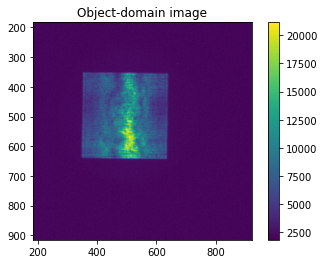

In [58]:
rs = RSpaceImage(filename=os.path.join(datapath,'rs35.csv'),
                 delimiter='\t')
rs.plot_image(zoom=1.5)

### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

**Why**

* Object distribution is obviously not centered in the computational domain. 

* Also, as it is sometimes happens in the data acquisition process, mutual orientation of the object- and Fourier-domain images may be wrong (i.e. horizontal and vertical axes in object-domain images can be either flipped or rotated with respect to those in Fourier-domain images). 

* Hence the data may need to be rotated and/or flipped.
* In the following example, the image is rotated counter-clockwise and flipped upside-down.

**How**

> Rotation can be done with ```rotate_image```method by setting
 * ```times_rot=1```to rotate counter-clockwise (default) only once
 * ```estimate_only``` to ```True``` if it is only required to estimate how the image will look like if rotated
 * ```estimate_only``` to ```False``` to perform the actual rotation
 * ```axes```to ```(1,0)``` to change the direction of the rotation to clockwise or just set the number of rotations to ```times_rot=3```

Object-domain: Input image was rotated


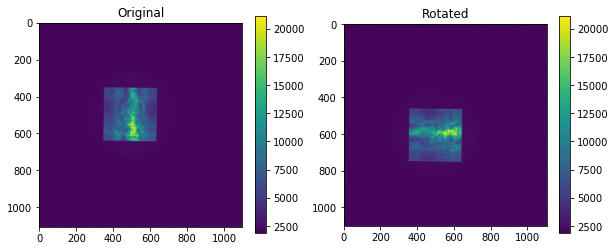

In [59]:
rs.rotate_image(times_rot=1, 
                estimate_only=False,
                plot_progress = True)

> Flipping is done using ```flip_image```method by setting

* ```estimate_only```to ```True```if it is only required to estimate how the image will look like if flipped 
* ```estimate_only```to ```False```to flip the image
* ```axis```to ```0``` to flip left-right as the method flips the image upside-down by default

Object-domain: Image was flipped


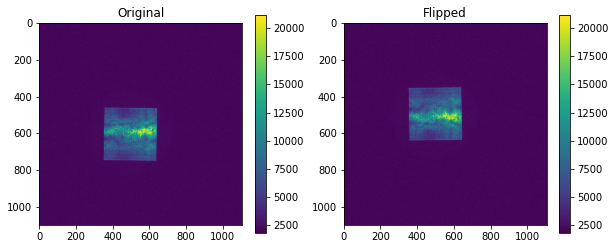

In [60]:
rs.flip_image(estimate_only=False, plot_progress = True)

### Histogram inspection <a class="anchor" id="histogram-inspection"></a>

* The image has correct orientation, but is still de-centered and most probably noisy.

* Let's inspect its histogram.

Text(0.5, 1.0, 'Histogram of the object-domain image, log scale')

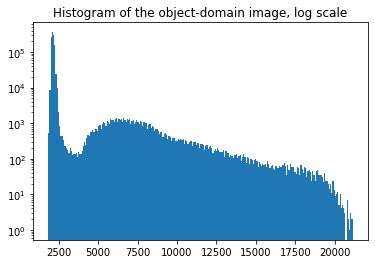

In [61]:
bin_counts, bin_edges, patches = plt.hist(rs.image.ravel(), bins=256, log=True)
plt.title("Histogram of the object-domain image, log scale")

* A histogram of the top-left corner of the object image reveals a peak at about 2200. Hence this peak is due to the sensor noise.

* A histogram of the central region of the object image reveals two peaks: at 2200 and 7000. The broad peak at 7000 belongs to the object distribution. The peak around 2200 is due to the sensor noise.

Text(0.5, 1.0, 'Histogram of a 200x200 patch at the top-left corner (only noise), log scale')

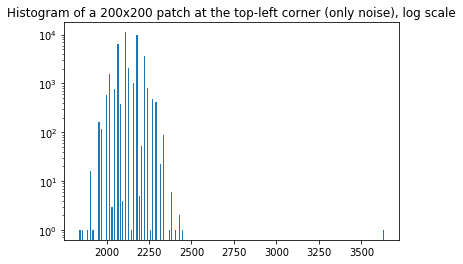

In [62]:
bin_counts, bin_edges, patches = plt.hist(rs.image[0:200,0:200].ravel(), bins=256, log=True)
plt.title("Histogram of a 200x200 patch at the top-left corner (only noise), log scale")

Text(0.5, 1.0, 'Histogram of a 200x200 patch in the centre (object distribution corrupted by noise)')

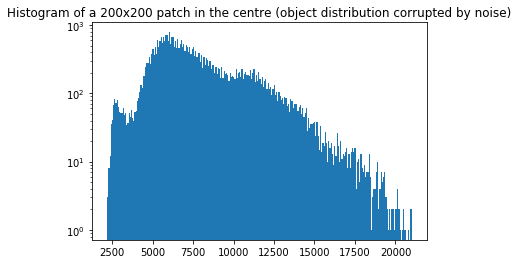

In [63]:
bin_counts, bin_edges, patches = plt.hist(rs.image[350:550,350:550].ravel(), bins=256, log=True)
plt.title("Histogram of a 200x200 patch in the centre (object distribution corrupted by noise)")

### Background subtraction

**Why**

* For experiments on how noise and quasi-constant background impact phase retrieval results refer to this paper: [[Latychevskaia-2018](#Latychevskaia-2018)]. In short,

* Experimenal images are noisy. When noise is added to the distribution in the object (or Fourier) domain, the result is not just noise being addded to the Fourier (or reconstructed object) image due to the object support constraint. If the noise is not properly eliminated, the quality of the reconstruction may be greatly impacted [[Latychevskaia-2018](#Latychevskaia-2018)].


**The preculiarity of the noise elimination in phase retrieval is that regular algorithms such as non-local means or Wiener filtering will modify the pixel values, which is not desired as this may grealty impact phase retrieval results.**


* The only method that preserves the original pixel values, whilst very effectively reducing noise, is **averaging over multiple images**. In this case, the magnitude of noise fluctuations drops by the square root of the number of images used for averaging (e.g. need to average over 4 images to reduce the noise magnitude by half. As a drawback, averaging leads to an accumulation of a constant background due to a non-zero-valued noise mean.

* The presence of a small constant background (a constant off-set) of $10^{-6}$ of maximal intensity in the image has no serious impact on the quality of the reconstruction [[Latychevskaia-2018](#Latychevskaia-2018)], but  must be subtracted otherwise. 

* From the histograms above, the ratio of the background's amplitude to the maximal intensity is $\approx 0.1 > 10^{-6}$ and thereby such a background must be subtracted.

**How**

> Background subtraction can be done using ```subtract_background```method of class ```RSpaceImage``` by setting:
* ```noise_mean = True``` to estimate the background's amplitude as the mean pixel value within a small patch set by  ```patch_corner``` and ```patch_size```
* ```noise_mean = False``` (default) and ```counts```  to manually define the number of counts to be subtracted from each pixel

> **At this point, set ```estimate_only=True```**. 
* This will only provide an estimate of the image after the background subtraction. 
* The background should be subtracted after completing the object segmentation as it is easier to complete in the presence of the background. 
* Upon object segmentation, subtract the background by setting ```estimate_only=False```

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:901: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(im_bgfree))


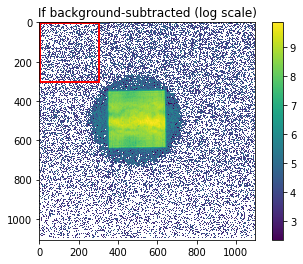

Object domain: This is how the image looks like if the background were subtracted.
Object domain: Background was set to  0


In [64]:
_ = rs.subtract_background( 
                       noise_mean = True,
                       patch_corner = (1,1),
                       patch_size= (300,300),
                       estimate_only=True, 
                       log_scale=True,
                       plot_progress = True)

Automatic estimation of the number of counts as the mean pixel value within the red patch leaves a significant number of counts around the object distribution unsubtracted because of the spatially non-uniform noise distribution.  

> The most reasonalble way to subtract the background completely would be to find the "right" the number of counts manually  by setting ```noise_mean = False``` 

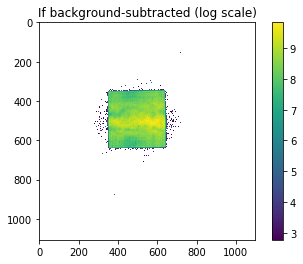

Object domain: This is how the image looks like if the background were subtracted.
Object domain: Background was set to  2400


In [65]:
COUNTS=2400

_ = rs.subtract_background(counts=COUNTS, 
                       noise_mean = False,
                       estimate_only=True, 
                       log_scale=True,
                       plot_progress = True)

### Object segmentation


**Why**

* Solving the phase problem requires that an object distribution is surrounded by a transmission function with known pixel values, e.g. 0 in the most simple case. Hence we must somehow estimate an extent of the object, the process known as object segmentation.

* As one can see from the figure above, subtracting the quasi-constant background and setting the negative-valued pixels to zero yields a rough estimate of the boundaries of the object distribution. However, it is not possible to obtain a good estimate of the segmented object distribution due to noise.


* Some of the methods for object segmentation suggested here are:
    1. marker-based watershed algorithm

#### Marker-based watershed segmentation

* Watershed segmentation is a region-based technique that utilizes image morphology.
* It requires selection of at least one marker ("seed" point) interior to each object of the image, including the background as a separate object.
* The markers are chosen by an operator or are provided by an automatic procedure using a priori knowledge about the object.
* Once the objects are marked, they can be grown using morphological watershed transformation.

<div style="align: left; text-align:center;">
    <img src = "watershed.png" style="width:350px"/>
    <div class="caption"> Regional minima, catchment basins and divide lines (From [[Meyer-Beucher-1990](#Meyer-Beucher-1990)].</div>
</div>

* To intuitively understand watershed, one can think of an image as a topographic surface where the bright pixels correspond to mountains and dark pixels correspond to valleys. The surface is punctured in some of the valleys and merged into a water bath. The water from different punctures is not allowed to mix. The dams are built at the points of the first contact. These dams are the boundaries of the water basins and also the boundaries of the image objects to be segmented. This principle is schematically shown in Fig. below. For marker-based watershed, the regional minima are replaced with the markers.

* In the following, one of the variants of watershed, non-parametric marker-based segmentation algorithm of Meyer, implemented in OpenCV, is used.

* It is implemented in ```rs.segment_image_watershed()```method as described below.

**How**

> Segmentation can be done with ```segment_image_watershed``` method by setting 
   *  structuring element size ```str_element_size``` used to estimate the sure foreground and the sure background images
   * physical linear pbject size  ```linear_object_size``` in meters to estimate the physical linear pixel size of the object-domain image

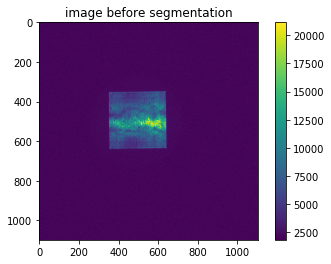

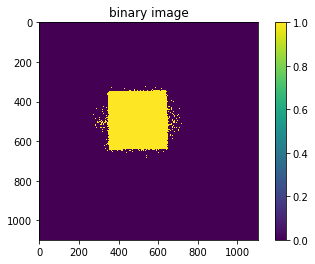

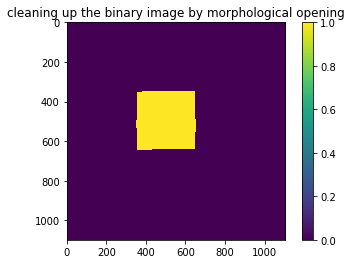

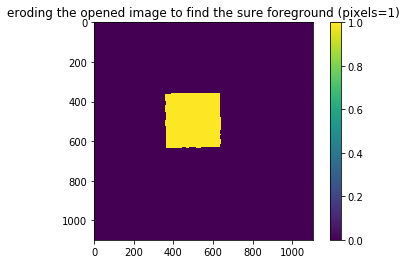

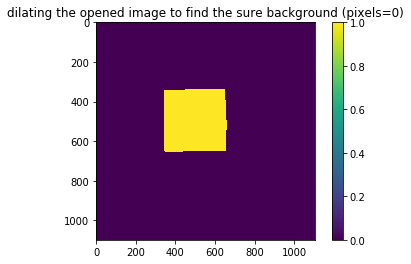

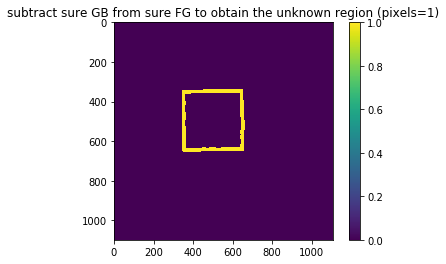

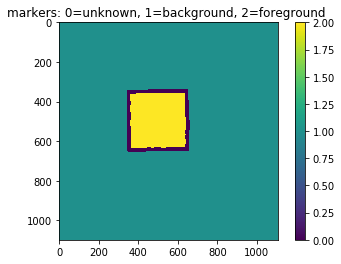

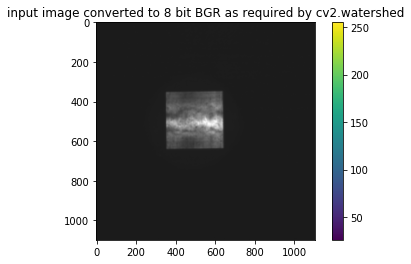

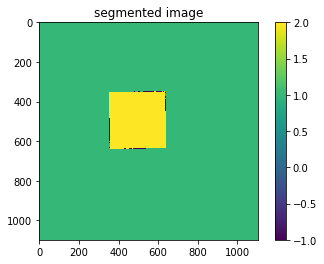

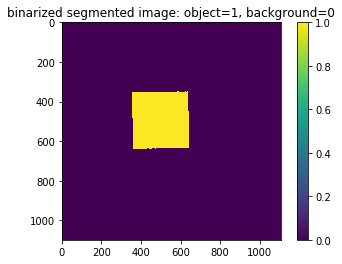

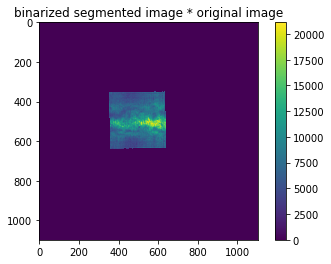

In [66]:
DR0 = rs.segment_image_watershed(str_element_size = 20, 
                           linear_object_size=100e-6,  
                           plot_progress = True)

##### Implementation details

```rs.segment_image_watershed()```method incorporates the following "black-box" steps:

   1. **Generate the foreground and background markers.**  
   
       * The binary image obtained upon calling ```rs.subtract_background()``` is used as a starting point. 
       * It is saved as an object-domain instance variable ```rs.image_binary``` and undergoes various morphological processing steps to obtain the sure foreground and the sure background markers.

 1.1 To obtain the sure foreground image, the boundaries of the binary image are first smoothed  by means of **morphological opening**.  This steps also removes small holes turning them into "1"s.

<div style="align: left; text-align:center;">
    <img src = "opening.png" style="width:250px"/>
    <div class="caption"> Morphological opening is morphological erosion followed by morphological dilation. Opening is very efficient in smoothening the contours of objects, breaking narrow isthmuses and eliminating protrusions. Dark blue: before, light blue: after the opening with circular structuring elements (From Wikipedia)</div>
</div>

   * In mathematical morphology, opening is the dilation of the erosion of a set A by a structuring element B:  $A\circ B=(A\ominus B)\oplus B$,  where $\ominus$ and $\oplus$ denote erosion and dilation, respectively. One can think of B sweeping around the inside of the boundary of A, so that it does not extend beyond the boundary, and shaping the A boundary around the boundary of the element. 

   1.2 The sure foreground is obtained by applying **erosion** to the morphologically opened binary image.
    
<div style="align: left; text-align:center;">
    <img src = "erosion.png" style="width:250px"/>
    <div class="caption"> Dark blue: before, light blue: after the erosion with circular structuring elements (From Wikipedia)</div>
</div>

   * Let $E$ be a Euclidean space or an integer grid, and $A$ a binary image in $E$. The erosion of the binary image $A$ by the structuring element $B$ is defined by: $A\ominus B=\{z\in E|B_{z}\subseteq A\}$, where $B_z$ is the translation of $B$ by the vector $z$, i.e. $B_{z}=\{b+z|b\in B\}, \forall z\in E$. When the structuring element $B$ has a center (e.g., a disk or a square), and this center is located on the origin of $E$, then the erosion of $A$ by $B$ can be understood as the locus of points reached by the center of B when B moves inside $A$ (From Wikipedia).

   1.3 Applying **dilation** to the morphologically opened binary images gives the sure background.
    
<div style="align: left; text-align:center;">
    <img src = "dilation.png" style="width:250px"/>
    <div class="caption"> Dark blue: before, light blue: after the dilation with circular structuring elements (From Wikipedia)</div>
</div>    

   * The dilation of the binary image $A$ is defined as $ A\oplus B=\{z\in E\mid (B^{s})_{z}\cap A\neq \varnothing \}$, where $B^s$ denotes the symmetric of $B$, that is, $B^{s}=\{x\in E\mid -x\in B\}$. If B has a center on the origin, then the dilation of A by B can be understood as the locus of the points covered by B when the center of B moves inside A.

**2. Mark all regions** 

   * The difference between the sure background and the sure foreground yields the boundary region (i.e. the region containing the sought object's boundary). 

   * All known regions are marked with positive integers and the boundary region is marked with 0.

**3. Convert the object-domain image to BGR 8 bit**

   * This is required by OpenCV  implementation of waterhsed.

**4. Apply watershed algorithm**
   
   * Parse converted object-domain image together with the markers into the watershed algorithm .

   * The result is saved as a **binary mask** in the object-domain instance variable ```rs.image_segmented```.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:941: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(self.image))


Object domain: Plotted in log scale


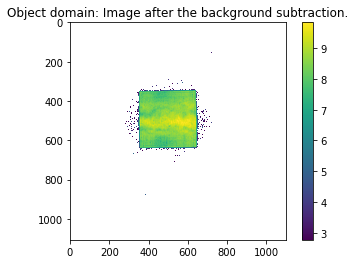

Object domain: Background of 2400 counts was subtracted.


In [67]:
_ = rs.subtract_background(counts=COUNTS, 
                       noise_mean = False,
                       estimate_only=False, 
                       log_scale=True,
                       plot_progress = True)

### Centering and zero-padding the segmented object-domain distribution

**Why**

* The next step is to perform centering of the image in the computational domain. Even a small offset by one pixel can have a dramatic effect on the resultant reconstruction [[Latychevskaia-2018](#Latychevskaia-2018)]. 

* To simulate a decay of the signal the edges of the object distribution, its boundaries are smoothed with a Gaussian filter. 

* The signal decay is of the order of a wavelength of light being imaged ($\lambda=$880 nm). The rs.segment_image_watershed method returns the pixel size $dr0$ = 351 nm. Hence the standard deviation can be estimated as $\sigma = [\lambda/dr0] \approx 3$ pixels, where $[]$ denote the floor function. As a truncation intverval for the Gaussian filter we choose $3\sigma$ as these contain 99.7\% of the values within the filter. 


**How**

> The centering can be done using ```centre_image``` method of class ```RSpaceImage```:

In [13]:
print(rs.centre_image.__doc__)


        Completes zero-padding of the object-domain image to a specified linear number of pixels.
        Centers the image by computing the centre of mass of its segmented distribution.
        Masks the centred image with its centred segmented distribution.
        Applies an apodization filter to the segmented image to smooth its boundaries (optional)

        ---
        Parameters
        ---
        npixels_pad: int, optional
            Linear number of pixels to have in the zero-padded object-domain image.
            Default is 2000.
        apodization: bool, optional
            If True, the boundaries of the centred segmented image are smoothed using a Gaussian filter
            with standard deviation = std pixels and truncation of the filter's boundaries to trunc pixels
            If False, the boundaries of the segmented image are not smoothed.
            Default is False.
         std: int, optional
            Standard deviation of a gaussian used to apodize the ob

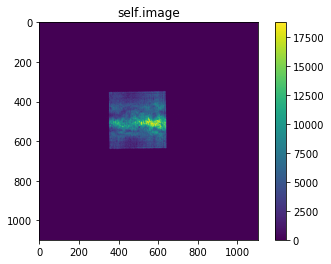

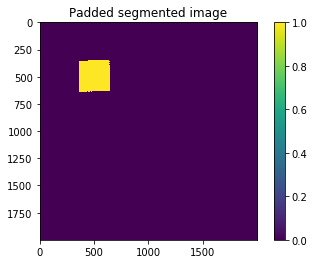

Object domain: Input and segmented images were padded to  2000 X 2000 pixels.


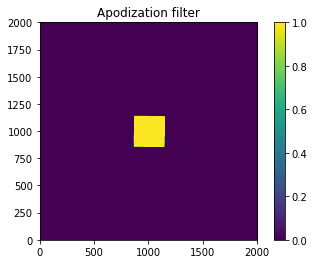

Object domain: Image centred. Apodization filter was applied. Linear pixel size is  3.5165952883213734e-07 nm


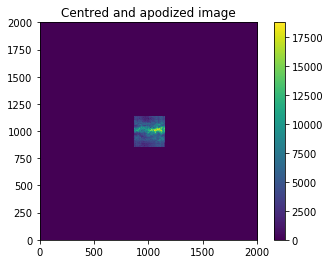

In [69]:
lambd = 880e-9

_ = rs.centre_image(npixels_pad = 2000, 
                    apodization = True,  
                    std = np.floor(lambd/dr0), trunc = 3*np.floor(lambd/dr0), 
                    plot_progress = True, zoom=1)

### Re-sampling <a class="anchor" id="resampling"></a>

**Why**

* The pixel sizes in the object image, $\Delta r$ [m], and Fourier image, $\Delta k$ [rad/m], are connected as 

(1): $\Delta r \Delta k = \frac{2\pi}{N}$,                      

where $N$ is the linear pixel number. Hence, equation (1) must be fulfilled for both images used in phase retrieval. Typically, this is not the case for raw data and either of images must be resampled to ensure the correct application of the discrete Fourier transform. 

* Let's assume the pixel sizes of the unprocessed object- and Fourier-domain images are $\Delta r_{oo}$ and $\Delta k_{FF}$, respectively. These pixel sizes are set by experimental conditions, such as optical magnification, and hence are fixed. 

* Object distribution is confined to $N_{oo}\times N_{oo}$ pixels area and is surrounded by a zero-padded region. The total area of the object-domain image is thus sampled with $N_o\times N_o$ pixels ($N_o > N_{oo}$), which is set either by imaging conditions or by choosing an appropriate width of the zero-padded region. 

* In Fourier domain, the size of the non-zero-valued area is set by the field of view of the imaging system to $N_{FF} \times N_{FF}$ pixels. If we set $N_{o}$ such that $N_{o}=N_{FF}$, then, according to equation (1), the effective size of the pixel in Fourier domain should be $\Delta k_\textrm{eff} = \frac{2\pi}{N_{o}\Delta r_{oo}}$.

* Typically, $\Delta k_\textrm{eff} \neq \Delta k_{FF}$, as both $\Delta r_{oo}$ and $\Delta k_{FF}$ are set by experimental conditions, which in most cases cannot be the same. Similarly, if $N_{o}=N_{FF}$, the effective size of the pixel in the object domain is $\Delta r_\textrm{eff} = \frac{2\pi}{N_{o}\Delta k_{FF}}$ and, typically, $\Delta r_\textrm{eff} \neq \Delta r_{oo}$. 

* The data must be thereby re-sampled in either domain to fulfill equation (1)


* In the following we define $D = \left[\frac{\Delta r_\textrm{eff}}{\Delta r_\textrm{oo}}\right]>1$, the downsampling ratio, where $[]$ denotes rounding to the nearest integer, as not necessarily $\frac{\Delta r_\textrm{eff}}{\Delta r_\textrm{oo}} \in \mathrm{Z}$. 

* We resample object domain images because, in our case, they have less high-frequency features and thus should be less prone to re-sampling-induced artifacts. 

**How**



> The resampling can be done with the ```resample_image``` method of class ```RSpaceImage``` by setting

> * ```fieldofview``` to **1/2** of the field of view in Fourier-space, in degrees (e.g. if the FOV is $\pm 17°$, set ```fieldofview=17```)
> * ```npixels_kspace``` to **1/2** of the linear number of non-zeros-valued pixels in Fourier-domain image (e.g. if the Fourier image is sampled at 726x726 pixels, set ```npixels_kspace=726/2```
> * ```pixelsize_dr0 ``` to the pixel size in experimental object-domain image, in meters
> * ```lambd``` to the wavelength of light used for imaging, in meters
> * ```estimate_only=False``` to  irreversibly resample the input image, and to ```True``` to only estimate the downsampling ratio.

In [9]:
print(rs.resample_image.__doc__)


        Resamples object-space image to equalise its pixel size to the one set by
        digital Fourier transform and the pixel size in the experimental Fourier-space image

        ---
        Parameters
        ---
        fieldofview: int, optional
            One half of field of view in Fourier-space, in degrees
            Default is ±17°, i.e. fieldofview = 17
        npixels_kspace: int, optional
            One half of linear number of non-zeros-valued pixels in experimental Fourier-space image to be used together with the real-space image
            (= corresponds to the linear number of pixels within the 1/2 of field of view)
            Default is 500
        pixelsize_dr0: int, optional
            Pixel size in experimental object-domain image, in m.
            If it is None, the value will be read from metadata (saved to metadata after centering and segmentation of the image).
            If the value in metadata is None, there will be an error message.
            

In [70]:
rs.resample_image(fieldofview = 17, 
                 npixels_kspace = 726/2,
                 pixelsize_dr0 = DR0,
                 lambd = 880e-9, 
                 estimate_only = True)

pixelssize_dk =  5750.768843441485
Object domain: Downsampling ratio = 2.0


(5750.768843441485, 5.462908941597696e-07, 2.0, 1553)

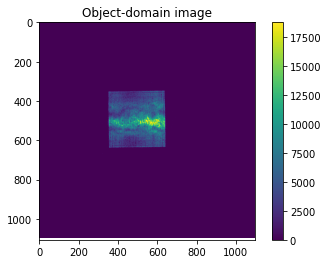

In [71]:
rs.plot_image(zoom=1)

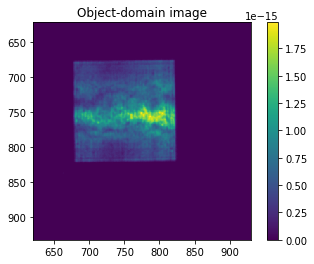

In [56]:
rs.plot_image(zoom=5)

* After re-sampling, the object-domain image will be zero-padded to a new linear number of pixels:

$N = \left[ \frac{2\pi}{D * \Delta r_{oo} * \Delta k_{FF}} \right]$      (2).

## Processing in the Fourier domain <a class="anchor" id="processing-in-the-fourier-domain"></a>

### Initialisation <a class="anchor" id="fourier-domain-initialisation"></a>

> A class for Fourier-domain images ```RSpaceImage``` is initialised equivalently.

In [180]:
from PhaseRetrieval.classes.kspaceimage import KSpaceImage
print(KSpaceImage.__init__.__doc__)


        Initializes Fourier-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file
            Delimiter needs to be specified if the data are to be loaded from a csv file.
            If None, then it is assumed that the data are to be loaded from a tif file.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        renorm_factor : float
            Renormalisation factor to fulfill Parseval's theorem
            If None, an empty class is created.
            Default is None.
        


### Read data <a class="anchor" id="read-data"></a>

> As soon as the class is imported, an image can be read by specifying the following keyword arguments: ```filename```,  ```delimiter```. Currently, only the csv and tif formats are supported.

In [181]:
ks = KSpaceImage(filename=os.path.join(datapath,'ks35.csv'),
                 delimiter='\t')

Fourier domain: Input image was read



> The loaded image can be plotted using ```plot_image``` method of ```KSpaceImage```class. To zoom into the image, set the keyword argument ```zoom``` to any float > 1. Logarithmic scale is by setting ```log_scale ```to ```True```.

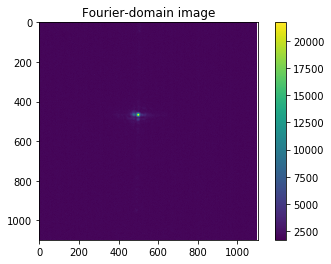

In [182]:
ks.plot_image(zoom=1, 
              log_scale = False)

### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

> Rotation is done by ```rotate_image``` method by setting

> * ```times_rot=1```to rotate only once

> * ```estimate_only``` to ```True``` if it is only required to estimate how the image will look like if rotated

> * ```estimate_only``` to ```False``` to perform the actual rotation. 

> Counter-clockwise rotaion by default. To change the direction of the rotation, either set the keyword argument  ```axes```to ```(1,0)``` or just set the number of rotations to ```times_rot=3```.

Fourier domain: Input image was rotated


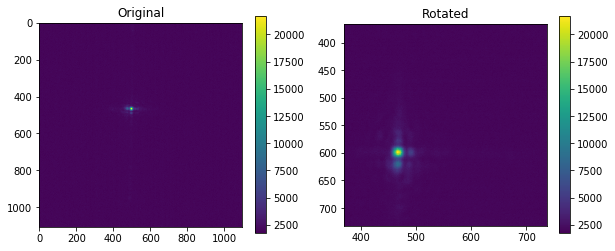

In [14]:
ks.rotate_image(times_rot=1, 
                zoom=3, 
                estimate_only=False,
                plot_progress = True)

> Flipping is done using ```flip_image```method. The method flips the image upside-down by default. To flip left-right, set the keyword argument ```axis```to ```0```. Set ```estimate_only```to ```True```to only estimate how the image will look like if flipped and to ```False```to perform the flipping.

Fourier domain: Input image was flipped


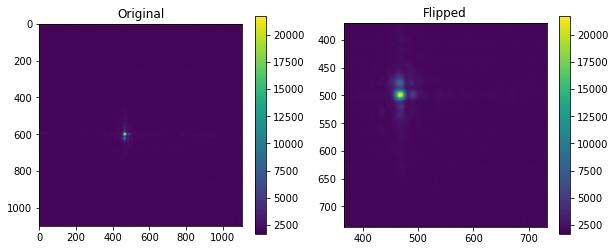

In [15]:
ks.flip_image(zoom=3, 
              estimate_only=False,
              plot_progress = True)

### Zero-padding and centering <a class="anchor" id="zero-padding-and-centering"></a>

* Just as the object-domain image, Fourier image must be centred for its use in phase retreival [[Latychevskaia-2018](#Latychevskaia-2018)]. 

> The image can be centred using ```centre_image```method of ```KSpaceImage```class.

In [16]:
print(ks.centre_image.__doc__)


        Centers the Fourier-domain image whose centre is located at one of its local maxima
        Completes zero-padding of the original image to a specified linear number of pixels

        ---
        Parameters
        ---
        roi: tuple, optional
            Region of interest (ROI) used to search for local maxima.
            Default is (0,10,0,10).
        centre: tuple, optional
            Centre of the image.
            Default is (1,1), which must be changed by user once the centre of the image (one of the local maxima) is found.
        gaussian_filter : bool, optional
            Apply Gaussian filter to filter noise
            Default is False
        sigma : float, optional
            Standard deviation of a Gaussian filter
            Defailt is 1.0
        min_distance, int, optional
            Minimal distance between the local maxima
            Must be tuned by user to make the search most effective.
            Default is 10.
        threshold_abs: float,

* The method centres Fourier image by finding local maximal within a specified region of interest (ROI). This methods suits well for centering purposes because Fourier images have multiple blobs that can be easily located. It is also assumed that one of these blobs is located exactly in the middle of the computational domain. 

/Users/Pavel/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


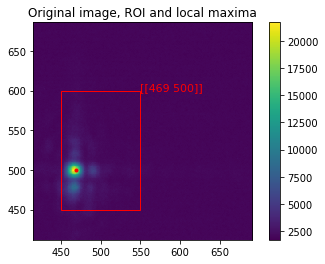

In [17]:
ks.centre_image(estimate_only = True, 
                centre = (469, 500), 
                roi=(450,450,550,600), 
                min_distance = 5, 
                threshold_abs = 5000, 
                num_peaks = 1,  
                zoom = 4, 
                npixels_pad = 2564,
                plot_progress = True)

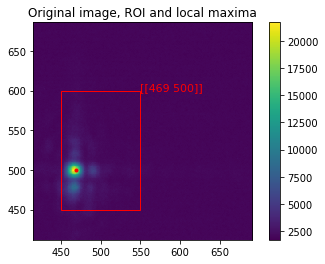

Fourier domain: Input image was padded to  2564 X 2564 pixels and centred.


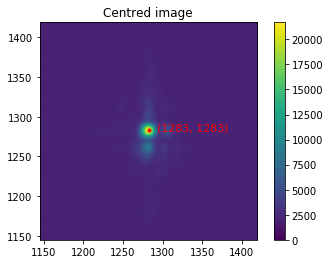

In [18]:
ks.centre_image(estimate_only = False, 
                centre = (469, 500), 
                roi=(450,450,550,600), 
                min_distance = 5, 
                threshold_abs = 5000, 
                num_peaks = 1,  
                zoom = 4, 
                npixels_pad = 2564,
                plot_progress = True)

> Optionally, the image can be centred manually by specifying the coordinates of its centre using ```centre_image_manually```method:
 ```ks.centre_image_manually(manual_centroid=(469, 500), npixels_final=2000```

### Background subtraction in Fourier images <a class="anchor" id="background-subtraction-in-Fourier-images"></a>

Similarly, we assume that the noise distribution is quasi-constant throughout the whole Fourier-domain image. The background is subtracted using ```subtract_background```method of class ```KSpaceImage```.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/kspaceimage.py:552: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(self.image))


Fourier domain: Plotted in log scale


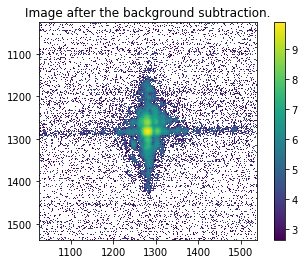

Fourier domain: Background of 2050 counts has been subtracted.


In [19]:
ks.subtract_background(counts = 2050, 
                       estimate_only=False,
                       zoom = 5,
                       log_scale = True,
                       plot_progress = True)

## Renormalisation (Parseval's theorem) <a class="anchor" id="renormalisation"></a>

Now when both images are correctly sampled and have equal linear number of pixels $N$, we must renormalise one of them to fulfill Parseval's theorem:

$\sum\limits_{i = 0}^{N-1}\sum\limits_{j=0}^{N-1} |x[i,j]|^2  = \frac{1}{N^2} \sum\limits_{m=0}^{N-1}\sum\limits_{n=0}^{N-1} |X[m,n]|^2 $, (3)


where $i,j$ refer to the object space coordinates and $m,n$ to the Fourier space coordinates. We renormalise the Fourier-domain image.

> Compute energy in the object domain

In [20]:
energy_rspace = sum(sum(rs.image))
print(energy_rspace)

464540396.0217333


> Renormalise in the Fourier domain.

In [21]:
ks.renormalise_image(energy_rspace)

Fourier domain: Energy =  3053933159324893.5
Energy in object's domain * total number of pixels:  3053933159324892.5
Fourier domain: Image was renormalised. Parseval's theorem is NOT fulfilled.


Equation (3) is now fulfilled.

## Saving processed images <a class="anchor" id="saving-processed-images"></a>

> Processed images are saved using ```save_as_tif``` method of ```RSpaceImage```and ```KSpaceImage``` classes. A user must enter a filename and specify a path to save the data. The data are saved as float32 data type.

In [22]:
ks.save_as_tif(pathtosave=datapath, outputfilename="ks_processed_amplitude.tif")


Fourier domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks_processed_amplitude.tif
Fourier domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks_processed_amplitude.csv


In [23]:
rs.save_as_tif(pathtosave=datapath, outputfilename="rs_processed_amplitude.tif")

Object domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.tif
Object domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.csv


The data are saved as float32 tif images. Its metadata are saved in csv files bearing the same names as the corresponding tif files.

# Phase retrieval <a class="anchor" id="phase-retrieval"></a>

## Phase retrieval from two intensity measurements<a class="anchor" id="from-two-intensity-measurements"></a>

Once object- and Fourier-domain images have been processed, they can be used for phase retrieval. Gerchberg-Saxton algorithm [[Gerchberg-Saxton-1972](#Gerchberg-Saxton-1972)] provides means of reconstructing object's phase from the modulus of the object's Fourier transform and  the object's (low-resolution) image.

Schematic of the algorithm is shown below. The algorithm starts with a random phase distribution in Fourier domain and iterates between both domains by computing the discrete Fourier transform. Computed amplitudes in both domains are replaced with the corresponding measured ones and the phase distributions are kept the same. 

The root mean square error serves as a quality metric in Fourier domain: $E = \frac{ \sum ||G| - |F||^2 }{\sum |F|^2}$ [[Fienup-1997](#Fienup-1997)], where $|G|$ is the modulus of computed data in Fourier domain and $|F|$ is the measured amplitude. The summation is over all pixels.

<img src = "gerchberg_saxton_scheme.png" style="width:900px"/>

## Oversampling requirements<a class="anchor" id="oversampling-requirements"></a>

Solution of the phase problem requires the fulfillment of the oversampling condition [[Miao-1998](#Miao-1998)]. The intensity of the light field scattered off the object provides the amplitude of the Fourier transform of the object distribution:

\begin{equation}
\left| F(m_1\Delta q, m_2\Delta q) \right| = \left| \sum\limits_{n_1=0}^{N-1}  \sum\limits_{n_2=0}^{N-1}  f(n_1 \Delta r, n_2 \Delta r) e^{-2\pi\mathbb{i}(m_1n_1 + m_2n_2)/N}\right|, (4)
\end{equation}

where $n_1, n_2 = 0,1,2,...,N-1$ are the sample numbers in the object domain and $m_1, m_2 = 0,1,2,...,N-1$ are the sample numbers in the Fourier domain. $f$ denotes complex-valued object and $F$ is  its Fourier transform. $\Delta r$ and $\Delta q$ are the samples in object and Fourier domains, respectively, connected as $\Delta r \Delta q = \frac{1}{N}$. 

Where $N$ is a linear number of pixels. Fourier-domain distribution (non-zero-valued pixels within the field of view) is sampled with $N_{FF}\times N_{FF}$ pixels. If the Fourier distribution is not zero-padded, then $N=N_{FF}$ and $N > N_{FF}$ otherwise. Object-distribution then has the same linear number of pixels  (non-zero-valued pixels) is sampled with $N_{oo} \times N_{oo}$ pixels (object distributions are typically confined so that $N_{oo} < N$).

Phase retrieval is equivalent to the solution of the system of equations (4). And to solve this system of equations uniquely, the number of equations must exceed the number of unknowns.

### Complex-valued object distribution, only Fourier amplitude is known

In case of a complex-valued object distribution, when only the Fourier amplitude distribution is known, there are $N_{FF}^2$ equations and $2N_{oo}^2$ unknowns (the factor 2 accounts for the real and imaginary parts of the object distribution). To solve the system of equations (4) uniquely, the number of known variables must exceed the number of unknown variables:


\begin{equation}
N_{FF}^2  > 2N_{oo}^2.
\end{equation}

[[Miao-1998](#Miao-1998)] defined the so-called oversampling ratio as the ratio between the total (non-zero-valued) pixel number and the number of pixels with unknown values:

\begin{equation}
\sigma = \frac{\text{Total pixel number}}{\text{Number of unknown pixels}} = \frac{N_{FF}^2}{N_{oo}^2}
\end{equation}

In case of a complex-valued object distribution, the so-called linear oversampling condition then reads as $\mathbb{O} = \sqrt{\sigma} > \sqrt{2}$.



### Complex-valued object distribution, amplitudes in both Fourier and object domains are known

In case of a complex-valued object distribution when both Fourier and object amplitude distributions are known, the number of equations stays ulaltered and is equal to $N_{FF}^2$. The number of unknowns is reduced to $N_{oo}^2$. 

To solve the system of equations (4) uniquely, the number of known variables must exceed the number of unknown variables:

\begin{equation}
N_{FF}^2 > N_{oo}^2.
\end{equation}

In this case, the linear oversampling ratio becomes $\mathbb{O} = \sqrt{\sigma} > 1$.




## Algorithm 1: Gerchberg-Saxton algorithm <a class="anchor" id="gerchberg-saxton-algorithm"></a>

> Import necessary packages; set ```datapath``` and ```sourcepath```.  Datapath contains object- and Fourier-domain data. Sourcepath contains the source code.

In [9]:
import sys,os
import shutil, glob

datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)

#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> Import ```phaseretrieval``` method of ```PhaseRetrieval```class and change the directory to the sourcepath (needed only in jupyter notebook, otherwise setting the paths suffice)

In [10]:
from PhaseRetrieval.classes.phaseretrieval import PhaseRetrieval
os.chdir(sourcepath)

> Initialise ```PhaseRetrieval```class and use previously saved processed images as inputs.

In [12]:
#initialise phase retrieval class
pr = PhaseRetrieval(filename_rspace=os.path.join(datapath,"Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif"), 
                    filename_kspace=os.path.join(datapath,"Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.tif"))

file type is tif
object-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif

object-domain metadata were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.csv

file type is tif
Fourier-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.tif

checking energy conservation ... 
rs energy 115012110.0
ks energy 562747860000000.0
rs energy * Ntot 562747823337728.0


Prior to application of phase retrieval algorithms, it makes sense to check if the oversamping ratio is fulfilled. The linear oversampling ratio must exceed ***$\sqrt{1}$*** for 2D data ***in case when both amplitude- and Fourier-domain images are available***. 

> This can be done using ```check_oversampling_ratio```method of ```PhaseRetrieval```class. Set the argument ```extrapolation```to ```False```. The method also prints out the metadata of the object-domain image.

In [13]:
pr.check_oversampling(extrapolation = False)

Wavelength of light, m                                             8.8e-07
Field of view, deg                                                      17
Number of pixels within the field of view                              500
Linear size of the object, m                                        0.0001
Pixel size object domain, m                                        3.4e-07
Linear number of pixels in the zero-padded real-space image           2000
Image centred and padded?                                              yes
Apodization filter applied?                                            yes
Parseval's theorem fulfilled?                                          NaN
Background subtracted?                                                 yes
Pixel size Fourier domain, 1/nm                                4.17506e+12
Pixel size object domain from padded Fourier data, 1/nm            752.467
dtype: object
linear oversampling ratio =  15.049335927266382
linear oversampling condition is fulfi

The oversampling ratio exceeds $\sqrt{1}$ and the data thus can be used in Gerchberg-Saxton algorithm, which is implemented in ```gerchberg_saxton```method of ```PhaseRetrieval```class. 
 
> The arguments ```gs_steps``` and ```plot_progress```set the number of iterations and allow to display the progress each ```plot_every_kth_iteration``` iteration, respectively. Here, for demonstration purposes, we set ```gs_steps=10```. In reality, from hundreds to thousands of iterations may be required.

The RMS error in Fourier domain decreases with each iteration as expected.

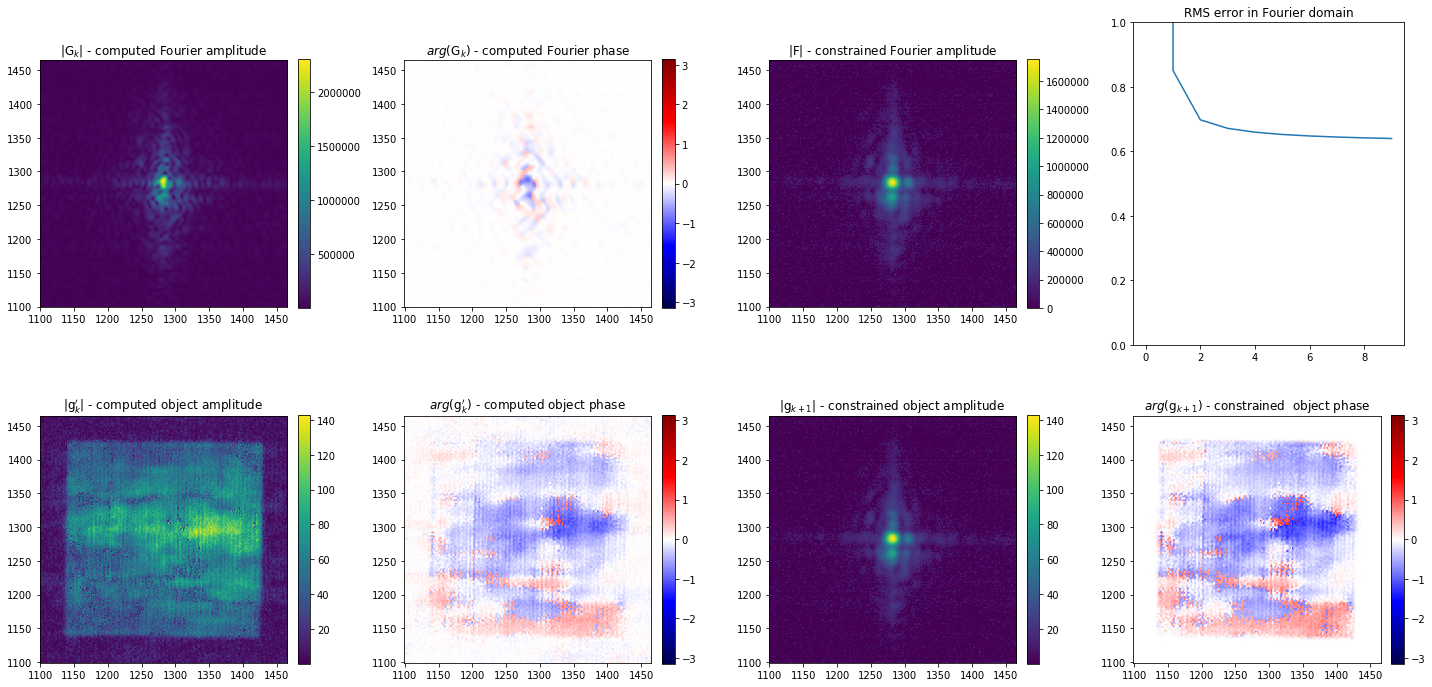

  completed


In [28]:
pr.gerchberg_saxton(gs_steps = 10, plot_progress = True, plot_every_kth_iteration = 2, zoom = 7)

Upon completeion, reconstructed images can be saved as csv files. **Because phase images may contain negative-valued pixels, saving in csv format preserves these negative pixel values by default.** Saving in tif with default parameters leads to the loss of negative values.

> Set  ```Fourier_amplitude```, ```Fourier_phase```, ```object_amplitude```, ```object_phase``` to ```True``` to save reconstructed Fourier amplitude, Fourier phase (top left corner in Fig. above), object amplitude and object phase images (bottom right corner in Fig. above), respectively.

In [29]:
pr.save_as_csv(filename="rs35ks35",
                pathtosave=datapath,
                Fourier_amplitude = True,
                Fourier_phase=True,
                object_amplitude=True,
                object_phase=True)

Fourier amplitude saved as  rs35ks35_Fourier_amplitude_163986000_20201001_084836.csv
Fourier phase saved as  rs35ks35_Fourier_phase_163986000_20201001_084836.csv
object amplitude saved as  rs35ks35_object_amplitude_163986000_20201001_084836.csv
object phase saved as  rs35ks35_object_phase_163986000_20201001_084836.csv


Filenames will indicate the corresponding saved image type (i.e. _object_phase_), followed by reciprocal space error recorded at the last iteration of the retrieval algorithm, date (YYYYMMDD) and time (HHMMSS). The error is given in format (1X000), where X are for digits of the decimal part of the error.

## Algorithm 2: Gerchberg-Saxton algorithm with extrapolation <a class="anchor" id="gerchberg-saxton-algorithm-with-extrapolation"></a>

In the example above, the object distribution is physically confined to the area sampled with $N_{oo}\times N_{oo}$ pixels and spatial extent of its diffraction pattern is limited by the field of view of the imaging system. To fulfill the requirements of the discrete Fourier transform, equation (1), the images were by re-sampled and zero-padded.

The spectrum of a size-limited object is infinite. Per definition, the discrete Fourier transform assumes the periodicity of the functions in both domains with the periods given by the linear number of pixels along each dimension. While zero-padding of the object-domain image can be justified due to the spatial confinement of the object, zero-padding in Fourier domain appears to be rather unnatural because the spectrum of the confined object distribution is infinitely extended and thus must not be truncated.

It is thereby makes sense to perform extrapolation of Fourier-domain data. Extrapolation of diffraction patterns in coherent diffraction imaging was suggested by [[Latychevskaia-2015](#Latychevskaia-2015)]. Here we follow the procedure described by Latychevskaia and co-workers.

We declare all zero-valued pixels in Fourier domain (including those which were set to zero upon the subtraction of the quasi-constant background) to be missing. The ratio between the number of missing pixels $N_\text{missing}$ and total pixel number $N_\text{total}$ is

\begin{equation}
f = \frac{N_\text{missing}}{N_\text{total}}.
\end{equation}

For zero-padded Fourier data, $N_\text{total} = N^2$. In object domain, there are $N_{oo}^2$ unknowns (object phases). Total number of measured (non-zero-valued) pixels is then $(1-f)N^2$. To solve the phase problem uniquely, the number of knowns must exceed the number of knowns.

\begin{equation}
(1-f)N^2  > N_{oo}^2,
\end{equation}

or, in terms of the linear oversampling ratio, $\mathbb{O}$, $f < 1 - \frac{1}{\mathbb{O}^2}$. 

**Example**

For $\mathbb{O} = 10.9$, we obtain f < 0.9916. Which means that even less than $1 \%$ of all Fourier domain pixels are enough to reconstruct both the object distribution and the missing pixel values in Fourier domain. In reality, however, the quality of the reconstruction heavily degrades when $f$ is high (i.e. higher than 0.6-0.7 [[Latychevskaia-2019](#Latychevskaia-2019)].)



Gerchberg-Saxton algorithm with extrapolation implemented in ```gerchberg_saxton_extrapolation```method of ```PhaseRetrieval```class. 
 
> The arguments ```gs_steps``` and ```plot_progress```set the number of iterations and allow to display the progress each ```plot_every_kth_iteration``` iteration, respectively. Here, for demonstration purposes, we set ```gs_steps=6```. In reality, from hundreds to thousands of iterations may be required.

The RMS error in Fourier domain decreases with each iteration as expected.

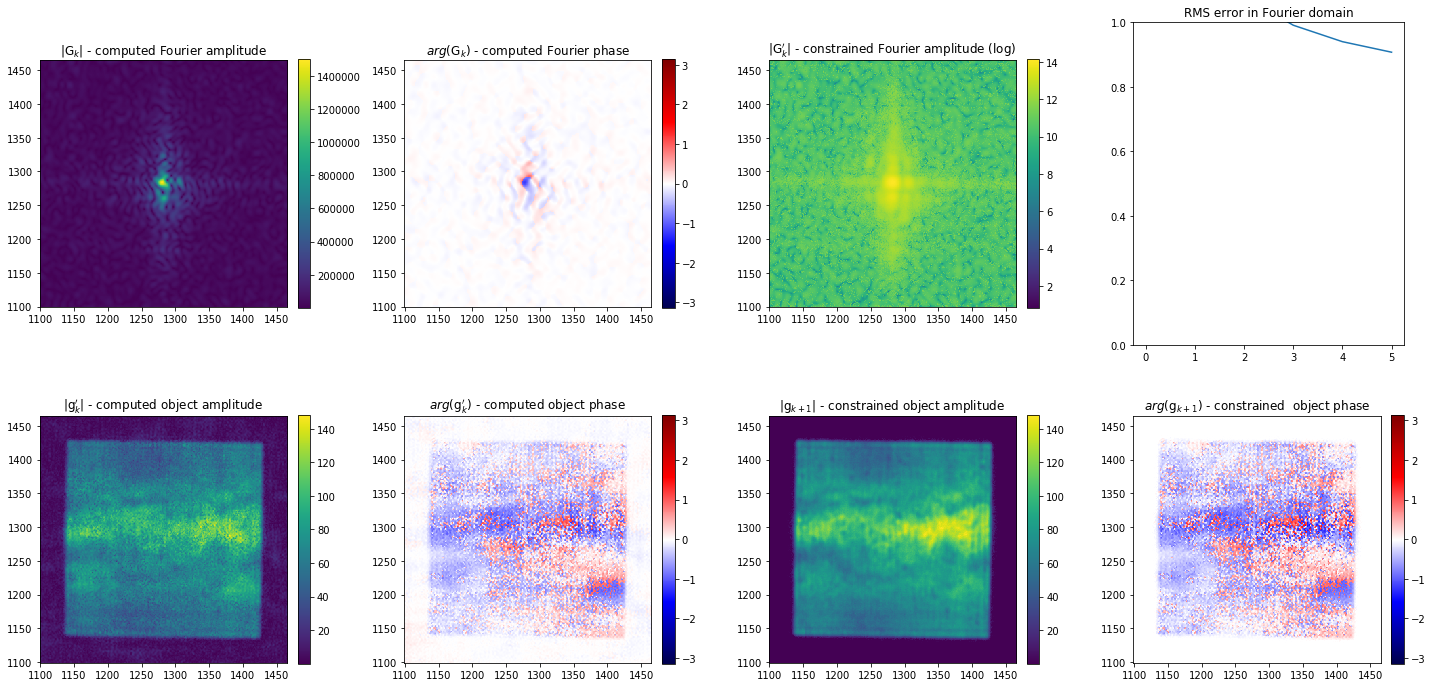

  completed


In [30]:
pr.gerchberg_saxton_extrapolation(gs_steps = 6, plot_progress = True, plot_every_kth_iteration = 2, zoom = 7)


# Automated procedures

* The whole phase retrieval procedure demonstrated above (i.e. image processing, Gerchberg-Saxton algorithm and image alignment) can be run unattended and asynchronously, without human supervision, as a batch job on a linux cluster. The following sections show examples of scripts that can be used in such shell scripts.

## Phase retrieval from two intensity measurements

### Complete code

### Explanation of the code

### Step 1: Image processing and generation of object and Fourier domain images with different linear number of pixels and different levels of subtracted noise

```preprocessing_script``` of the ```PhaseRetrieval``` framework allows to obtain processed images with different widths of the zero-padded regions (thus for different linear number of pixels) and different levels of subtracted noise in both domains. Varying the linear number of pixels changes the number of missing pixels to be recovered in the Gerchberg-Saxton algorithm with extrapolation and thus, together with different levels of subtracted noise, may have an impact on the quality of the reconstructions. 

We consider images having the same linear number of pixels and the same level of subtracted noise to be "of the same type".

> Import necessary packages, set ```datapath``` and ```sourcepath```.  Datapath contains object- and Fourier-domain data. Sourcepath contains the source code.

In [135]:
import sys,os
import shutil, glob

datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'
#datapath = '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)

#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> Import ```phaseretrieval``` method of ```PhaseRetrieval```class and change the directory to the sourcepath (needed only in jupyter notebook, otherwise setting the paths suffice)

In [110]:
from PhaseRetrieval.classes.phaseretrieval import PhaseRetrieval
os.chdir(sourcepath)

> Using ```preprocessing_script``` complete image processing for different linear number of pixels and noise. The function saves processed images under the specified datapath.

> The last three arguments ```npixels_pad_iter```, ```ks_noise_iter``` and ```rs_noise_iter``` are iterable and must be provided as lists of integers. The rest of the parameters are set equal to those used in section [Image processing for phase retrieval](#image-processing-for-phase-retrieval).

In [111]:
from PhaseRetrieval.scripts.scripts import preprocessing_script

preprocessing_script(datapath = datapath,
                       rs_filename = "rs35.csv",
                       ks_filename = "ks35.csv",
                       delimiter = '\t',
                       lambd=880e-9,
                       rs_pixelsize=340e-9,
                       rs_linear_object_size=100e-6,
                       ks_fieldofview = 17,
                       ks_npixels = 500,
                       ks_centre=(467, 500),
                       ks_gaussian_filter=True,
                       ks_sigma=1,
                       ks_roi=(400, 400, 550, 550),
                       ks_min_distance=5,
                       ks_threshold_abs=5000,
                       ks_num_peaks=5,
                       npixels_pad_iter = [2000],
                       ks_noise_iter = [1900, 2000],
                       rs_noise_iter = [2500],
                       suppress_print = False)

Processing images... Processing with linear number of pixels =  2000 ,Fourier-domain noise =  1900 ,Object-domain noise =  2500
Object domain: Input image was read
Object-domain: Input image was rotated
Object-domain: Image was flipped
Fourier domain: Input image was read
Fourier domain: Input image was rotated
Fourier domain: Input image was flipped
Object domain: Background of 2500 counts was subtracted.
Object domain: Input and watershed images were padded to  2000 X 2000 pixels.
Object domain: Image centred. Apodization filter was applied. Linear pixel size is  0.0 nm
Object domain: Input image shape is  2000 X 2000
Object domain: Image was resampled and its current shape is (1000, 1000)
Object domain: Image was resampled with the downsampling ratio = 2.0 and zero-padded to npixels_final X npixels_final= 2212 X 2212 pixels
Fourier domain: Input image was padded to  2212 X 2212 pixels and centred.
Fourier domain: Background of 1900 counts has been subtracted.
Fourier domain: Energy 

> Plot the result for the last data set

In [85]:
ks.plot_image(zoom=6)
rs.plot_image(zoom=6)

NameError: name 'ks' is not defined

### Step 2: Apply Gerchberg-Saxton algorithm with extrapolation to the processed images

> Unattended reconstruction by GS algorithm with extrapolation can be done by means of ```gerchberg_saxton_extrapolation_script```.

In [112]:
from PhaseRetrieval.scripts.scripts import gerchberg_saxton_extrapolation_script
print(gerchberg_saxton_extrapolation_script.__doc__)


    Script to launch GS algorithm with extrapolation and save reconstructed images.
    Customized for the case when image are saved in several folders (e.g. each containing images with different parameters)
    Reconstructed images are saved as csv (no metadata) in individual folders containing images of the same kind (e.g. equal number of pixels)
    ---
    Parameters
    ---
    files_extension: {"*.tif", "*.csv"}
        Extension of raw images.
        Must be chosen from the given set of extensions, i.e. either "*.tif" or "*.csv".
        Default is "*.tif".
    ---Initialisation of PhaseRetrieval class-related:---
    datapath: str
        Path used to load data (the same as used to load raw data).
        Default is None.
    rs_prefix: str
        Prefix common to names of the files containing object-domain images.
        Default is None.
    ks_filename: str
        Prefix common to names of the files containing Fourier-domain images.
        Default is None.
    ---
    -

In [119]:
gerchberg_saxton_extrapolation_script(datapath = datapath,
                                   rs_prefix = "rs35",
                                   ks_prefix = "ks35",
                                   files_extension = "*.tif",
                                   gs_steps = 3,
                                   plot_progress = True,
                                   plot_every_kth_iteration = 10,
                                   zoom=6,
                                   Fourier_amplitude = True,
                                   Fourier_phase = True,
                                   object_amplitude = True,
                                   object_phase = True,
                                   filename = "rs35_ks35_",
                                   rec_number = 2,
                                   print_progress = True)

/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif
Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif
Ntot2000rsnoise2500ksnoise1900_rs35_amplitude
file type is tif
object-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif

object-domain metadata were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.csv

file type is tif
Fourier-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_ks35_amplitude.tif

Iteration 1 
  completed 
Iteration 2 
  completed 
Iteration 3 
  completed 
Fourier amplitude saved as  rs35_ks35__Fourier_amplitude_102546000_20201007_171534.csv
Fourier phase saved as  rs35_ks35__Fourier_phase_102546000_20201007_171534.csv
object amplitude saved as  rs35_ks35__object_amplitude_102546000_20201007_171534.csv
object phase saved

For each type of the processed images (i.e. images having the same linear number of pixels and the level of subtracted noise), ```gerchberg_saxton_extrapolation_script```generates a directory, in which it copies the corresponding object- and Fourier-domain images and saves reconstructed distributions. The output file structure under ```datapath``` looks as follows:

* Amplitude, object domain, raw data (typically .tif)
* Amplitude, Fourier domain, raw data (typically .tif)

*


* Amplitude, object domain, image type 1 (saved as .tif)
* Amplitude, object domain, metadata of image type 1 (saved as .csv)
* Amplitude, Fourier domain, image type 1 (saved as .tif)
* Amplitude, Fourier domain, metadata of image type 1 (saved as .csv)


* Folder with copies images of type 1 and reconstructed images:

    * Amplitude, object domain, image type 1 (saved as .tif)
    * Amplitude, Fourier domain, image type 1 (saved as .tif)
    * Reconstructed phase, object domain, using images type 1, reconstruction 1 (saved as .csv)
    * Reconstructed phase, object domain, using images type 1, reconstruction 2 (saved as .csv)
    * ...
    * Reconstructed phase, object domain, using images type 2, reconstruction ```rec_number``` (saved as .csv)


* Amplitude, object domain, image type 2
* Amplitude, object domain, metadata of image type 2 (saved as .csv)
* Amplitude, Fourier domain, image type 2
* Amplitude, Fourier domain, metadata of image type 2 (saved as .csv)


* Folder with copies images of type 2 and reconstructed images:

    * Amplitude, object domain, image type 2 (saved as .tif)
    * Amplitude, Fourier domain, image type 2 (saved as .tif)
    * Reconstructed phase, object domain, using images type 2, reconstruction 1 (saved as .csv)
    * Reconstructed phase, object domain, using images type 2, reconstruction 2 (saved as .csv)
    * ...
    * Reconstructed phase, object domain, using images type 2, reconstruction ```rec_number``` (saved as .csv)

...

Reconstructed images are saved with self-descriptive strings in their filenames, such as  ```_object_phase_```or ```_Fourier_amplitude_```.

### Step 3: Alignment of reconstructed phase images

Final reconstruction is typically by averaging 5% of reconstructed phase images having the lowest RSE metric. Reconstructed phase images are in spatial registry (because object-domain amplitude image was used as input to GS algorithm). However, they have an arbitrary phase shift which must be leleved prior to averaging. We call thi procedure phase alignment. Phase alignment can be done with  ```phase_alignment_gerchberg_saxton``` method as demonstrated in the previous section or  unattended by using ```phase_alignment_gerchberg_saxton_script```, if, for example, an alignment in multiple folders is needed.

In [120]:
from PhaseRetrieval.scripts.scripts import phase_alignment_gerchberg_saxton_script
#print(help(phase_alignment_gerchberg_saxton_script))

> In the following, ```phase_prefix``` argument is set to ```"_object_phase_"```, although one can also align Fourier-domain phase images by setting it to ```"_Fourier_phase"```.

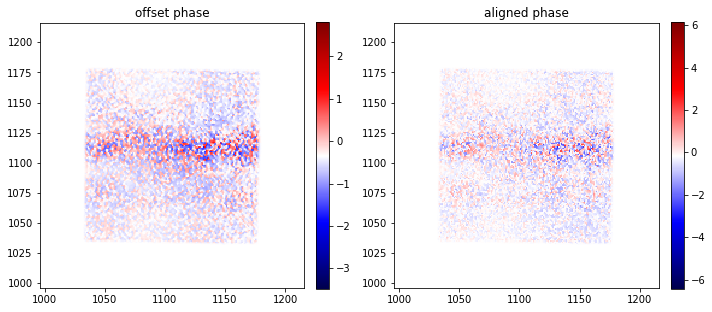

averaging 
aligned phase norm [[ 0.55302396  1.06266504  2.22009319 ... -0.19402174 -0.00691365
   0.38124756]
 [ 0.68565442  1.62986121  2.09657196 ...  2.33912729 -0.53449336
   0.17739375]
 [ 1.71425972  1.9808816   1.26644698 ...  0.90872503 -0.03110331
   0.5397926 ]
 ...
 [ 2.0263306  -0.01319548 -0.36205547 ...  0.30582358  0.02347751
   1.60670402]
 [ 1.96928102  0.6342741  -0.36305124 ... -1.85969217 -0.90656699
   2.04469983]
 [ 0.67589419  0.77583373  0.28305186 ... -2.08881241 -0.32356591
  -0.01687323]]
Aligned phase distribution was saved as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude/Ntot2000rsnoise2500ksnoise2000_rs35_phase.csv


In [143]:
phase_alignment_gerchberg_saxton_script(datapath = datapath,
                                 folder_prefix = "Ntot",
                                 amplitude_prefix = "*_rs35_amplitude.tif", 
                                 phase_prefix = "_object_phase_",
                                 delimiter = '\t',
                                 num_files_to_align=2,
                                 ref_coordinates = None,
                                 symmetric_phase = False,
                                 plot_progress = True,
                                 plot_every_kth_iteration = 1,
                                 zoom = 10,
                                 print_progress = True)
#print(filenames_list)
#print(phase_filenames)

> Plot aligned reconstructed images

In [141]:
print(os.listdir(datapath))

['.DS_Store', 'ks35.csv', 'Ntot2000rsnoise2500ksnoise1900_ks35_amplitude.csv', 'Ntot2000rsnoise2500ksnoise1900_ks35_amplitude.tif', 'Ntot2000rsnoise2500ksnoise1900_rs35_amplitude', 'Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.csv', 'Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif', 'Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.csv', 'Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.tif', 'Ntot2000rsnoise2500ksnoise2000_rs35_amplitude', 'Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.csv', 'Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif', 'rs35.csv']


**Note: phase images must be copied from their individual folders into a common folder with raw data**

['/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_phase.csv', '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_phase.csv']


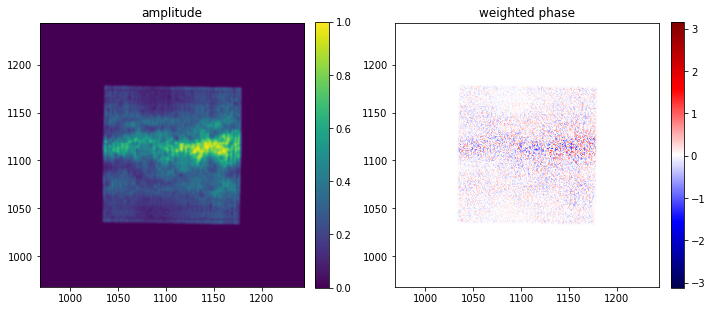

/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif


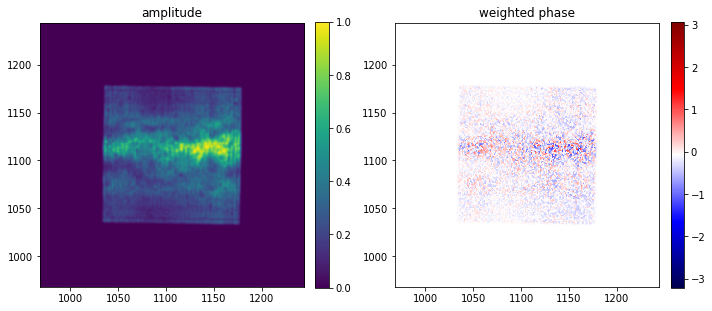

/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif


In [145]:
import os
from PhaseRetrieval.modules.postprocessing import plot_reconstruction

datapath = datapath

amplitude_filenames =  [os.path.abspath(os.path.join(datapath, p)) for p in os.listdir(datapath) if p.endswith(('rs35_amplitude.tif'))]
phase_filenames =  [os.path.abspath(os.path.join(datapath, p)) for p in os.listdir(datapath) if p.endswith(('rs35_phase.csv'))]
#print(amplitude_filenames)
print(phase_filenames)

for amplitude_filename, phase_filename in zip(amplitude_filenames, phase_filenames):
    plot_reconstruction(amplitude_filename = amplitude_filename, phase_filename = phase_filename, delimiter = '\t', zoom = 8)
    print(amplitude_filename)

# References <a class="anchor" id="references"></a>

[Fienup-1997] J. R. Fienup.  Invariant error metrics for image reconstruction . Appl. Opt. 36, 8352–8357 (1997).

[Gerchberg-Saxton-1972] R. W. Gerchberg and W. O. Saxton, "A practical algorithm for the determination of the phase from image and diffraction plane pictures,” Optik 35, 237 (1972) <a class="anchor" id="Gerchberg-Saxton-1972"></a>

[Latychevskaia-2015] T. Latychevskaia et al., Imaging outside the box: Resolution enhancement in X-ray coherent diffraction imaging by extrapolation of diffraction patterns, Appl. Phys. Lett. 107, 183102 (2015) <a class="anchor" id="Latychevskaia-2015"></a>


[Latychevskaia-2018] T. Latychevskaia, Iterative phase retrieval in coherent diffractive imaging: practical issues Applied Optics, 57 (25) (2018) <a class="anchor" id="Latychevskaia-2018"></a>


[Latychevskaia-2019] T. Latychevskaia, Reconstruction of missing information in diffraction patterns and holograms, Optics Communications, 56-67 (2019) <a class="anchor" id="Latychevskaia-2019"></a>

[Meyer-Beucher-1990] F. Meyer and S. Beucher, Morphological segmentation, manuscript number N-11/90_MM, 58 pages, Fontainebleau, France, 1990

[Miao-1998] J.W. Miao, D. Sayre, H.N. Chapman, Phase retrieval from the magnitude of the Fourier transforms of nonperiodic objects, J. Opt. Soc. Am. A, 15 (1998) 1662–1669. <a class="anchor" id="Miao-1998"></a>